# SNA - Project in Google Colab

## Colab Preparation

**Keep Alive**

When training google colab tends to kick you out, This might help: https://medium.com/@shivamrawat_756/how-to-prevent-google-colab-from-disconnecting-717b88a128c0

**Get Started**

Run the following script to mount google drive and install needed python packages. Pytorch comes pre-installed.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
%cd /content/drive/MyDrive/sna/

/content/drive/MyDrive/sna


In [20]:
!ls

archive				  GraphSage_LinkPrediction22_Copy1.ipynb  parameter_results.csv
data				  GraphSage_LinkPrediction22.ipynb	  README.md
exploratory			  GraphSage-LinkPrediction2.ipynb	  requirements.txt
graph.pkl			  GraphSage-LinkPrediction.ipynb	  scripts
GraphSage_LinkPrediction21.ipynb  models


#### Install libraries

In [5]:
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.3/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 6.1 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.21.5
    Uninstalling nvidia-nccl-cu12-2.21.5:
      Successfully uninstalled nvidia-nccl-cu12-2.21.5
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are instal

In [21]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import pickle

### 1. Link prediction with GNN
Assume we are given a graph g with incomplete data, for example, only 50% of the edges are present.

The goal is to predict **whether there is an edge** between any 2 nodes in g.

In [38]:
import pickle

# Load the graph
with open('exploratory/graph_directed_month.pkl', 'rb') as f:
    g = pickle.load(f)

g = dgl.from_networkx(g, edge_attrs=['count'])

# Verify the loaded graph
print(f"Number of nodes: {g.number_of_nodes()}")
print(f"Number of edges: {g.number_of_edges()}")
print("Edge data keys:", g.edata.keys())


Number of nodes: 10934
Number of edges: 1025406
Edge data keys: dict_keys(['count'])


Running model on a subsetted graph

In [47]:
import random

def create_subset(g, num_nodes=1000):
    """
    Creates a subgraph with a subset of nodes and their edges.
    Args:
        g (DGLGraph): The original graph.
        num_nodes (int): Number of nodes to include in the subgraph.
    Returns:
        DGLGraph: The subset graph.
    """
    # Sample nodes
    sampled_nodes = list(range(num_nodes))

    # Create a subgraph with the sampled nodes
    subset_g = g.subgraph(sampled_nodes)
    return subset_g

# Create the subset
g_subset = create_subset(g, num_nodes=1000)

# Save the subset graph
with open('exploratory/graph_directed_subset.pkl', 'wb') as f:
    pickle.dump(g_subset, f)

print(f"Subset Graph - Number of nodes: {g_subset.num_nodes()}")
print(f"Subset Graph - Number of edges: {g_subset.num_edges()}")

Subset Graph - Number of nodes: 1000
Subset Graph - Number of edges: 9102


Transforming Edge features into Node Features

In [48]:
import torch

# Initialize node features as zeros
num_nodes = g.num_nodes()
node_features = torch.zeros((num_nodes, 1))  # One-dimensional node features

# Aggregate edge counts into node features
for src, dst, edge_data in zip(*g.edges(), g.edata['count']):
    node_features[src] += edge_data
    node_features[dst] += edge_data  # Assuming undirected graph

# Assign aggregated features to nodes
g.ndata['feat'] = node_features
print("Node features (aggregated edge counts):\n", g.ndata['feat'])

Node features (aggregated edge counts):
 tensor([[ 6.],
        [34.],
        [26.],
        ...,
        [ 2.],
        [ 4.],
        [16.]])


Train/test split and obtaining positive edges

In [49]:
np.random.seed(42)  # For reproducibility
edge_ids = np.arange(g.num_edges())
edge_ids = np.random.permutation(edge_ids)

train_size = int(0.8 * len(edge_ids))
train_mask = edge_ids[:train_size]
test_mask = edge_ids[train_size:]

# Remove test edges to create g_main
g_main = dgl.remove_edges(g, test_mask)

# Extract edges
u, v = g.edges()

# Positive edges for training and testing
train_pos_u, train_pos_v = u[train_mask], v[train_mask]
test_pos_u, test_pos_v = u[test_mask], v[test_mask]

Generation of negative edges

In [50]:
# Create adjacency matrix
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj = adj.todense() + np.eye(g.num_nodes())  # Add self-loops to avoid sampling them as negatives

# Get non-edges
u_neg, v_neg = np.where(adj == 0)

# Sample negative edges
neg_ids = np.random.choice(len(u_neg), len(u))
train_neg_u, train_neg_v = u_neg[neg_ids[:train_size]], v_neg[neg_ids[:train_size]]
test_neg_u, test_neg_v = u_neg[neg_ids[train_size:]], v_neg[neg_ids[train_size:]]

Train/test graph creation

In [51]:
# Training graphs
g_train_pos = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.num_nodes())
g_train_pos.edata['count'] = g.edata['count'][train_mask]  # Copy 'count' attribute

g_train_neg = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.num_nodes())
g_train_neg.edata['count'] = torch.zeros(train_neg_u.shape[0])  # No count for negative edges

# Testing graphs
g_test_pos = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.num_nodes())
g_test_pos.edata['count'] = g.edata['count'][test_mask]  # Copy 'count' attribute

g_test_neg = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.num_nodes())
g_test_neg.edata['count'] = torch.zeros(test_neg_u.shape[0])  # No count for negative edges

### 2. GNN with SageConv
dgl.nn.SAGEConv(in_dim, out_dim) updates in the following way

\begin{align*}
h_i^{(l+1)}&= W.\text{concat}(h_i^{(l)},h_{N(i)}^{(l+1)})+b \ \text{with} \\ h_{N(i)}^{(l+1)}&=\text{Mean}\{h_j^{(l)}, j\in N(i)\}
\end{align*}

Here is our **model structure**
<center>
input -> SAGEConv1 -> relu -> SAGEConv2 -> predictor
<end><center>


In [52]:
import dgl.function as fn
from dgl.nn import SAGEConv

from sklearn.metrics import roc_auc_score # for computing auc metric

class GraphSage(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim, aggregator_type="mean")
        self.conv2 = SAGEConv(hidden_dim, hidden_dim, aggregator_type="mean")

    def forward(self, g, features):
        h = self.conv1(g, features)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

    def predict(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))  # Compute edge scores
            return g.edata['score'].squeeze()  # Ensure the result is 1D


    def loss(self, pos_scores, neg_scores):
        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([torch.ones(pos_scores.shape[0]), torch.zeros(neg_scores.shape[0])])
        return F.binary_cross_entropy_with_logits(scores, labels)

    def auc_score(self, pos_scores, neg_scores):
        scores = torch.cat([pos_scores, neg_scores]).detach().numpy()
        labels = torch.cat([torch.ones(pos_scores.shape[0]), torch.zeros(neg_scores.shape[0])]).detach().numpy()
        return roc_auc_score(labels, scores)

### 3. Train and Test

In [53]:
from sklearn.metrics import accuracy_score

def train(model, g_main, g_train_pos, g_train_neg, optimizer):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    h = model(g_main, g_main.ndata['feat'])

    # Predict scores for positive and negative training edges
    pos_scores = model.predict(g_train_pos, h)
    neg_scores = model.predict(g_train_neg, h)

    # Calculate loss
    loss = model.loss(pos_scores, neg_scores)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Combine scores and labels for AUC and accuracy
    scores = torch.cat([pos_scores, neg_scores]).detach().numpy()
    labels = torch.cat([torch.ones(pos_scores.shape[0]), torch.zeros(neg_scores.shape[0])]).detach().numpy()

    # Compute ROC AUC
    auc = roc_auc_score(labels, scores)

    # Compute Accuracy (using threshold = 0.5)
    predicted_labels = (scores >= 0.5).astype(int)
    accuracy = accuracy_score(labels, predicted_labels)

    return loss.item(), auc, accuracy


In [54]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluate(model, g_main, g_test_pos, g_test_neg):
    model.eval()
    h = model(g_main, g_main.ndata['feat'])

    # Predict scores for positive and negative test edges
    pos_scores = model.predict(g_test_pos, h)
    neg_scores = model.predict(g_test_neg, h)

    # Calculate loss
    loss = model.loss(pos_scores, neg_scores)

    # Combine scores and labels for AUC and accuracy
    scores = torch.cat([pos_scores, neg_scores]).detach().numpy()
    labels = torch.cat([torch.ones(pos_scores.shape[0]), torch.zeros(neg_scores.shape[0])]).detach().numpy()

    # Compute ROC AUC
    auc = roc_auc_score(labels, scores)

    # Compute Accuracy (using threshold = 0.5)
    predicted_labels = (scores >= 0.5).astype(int)
    accuracy = accuracy_score(labels, predicted_labels)

    return loss.item(), auc, accuracy

In [55]:
# Hyperparams and initialization of the model
from torch.optim import Adam

# Initialize model and optimizer
in_dim = g_main.ndata['feat'].shape[1]
hidden_dim = 16
model = GraphSage(in_dim, hidden_dim)
optimizer = Adam(model.parameters(), lr=0.01)

In [56]:
print("Edge data in g_main:", g_main.edata.keys())
print("Edge data in g_train_pos:", g_train_pos.edata.keys())
print("Edge data in g_train_neg:", g_train_neg.edata.keys())


Edge data in g_main: dict_keys(['count'])
Edge data in g_train_pos: dict_keys(['count'])
Edge data in g_train_neg: dict_keys(['count'])


In [57]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    train_loss, train_auc, train_accuracy = train(model, g_main, g_train_pos, g_train_neg, optimizer)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, AUC: {train_auc:.4f}, Accuracy: {train_accuracy:.4f}")

Epoch 1/50, Loss: 2863241.2500, AUC: 0.3143, Accuracy: 0.5013
Epoch 2/50, Loss: 2269236.0000, AUC: 0.2951, Accuracy: 0.5022
Epoch 3/50, Loss: 1773165.1250, AUC: 0.2797, Accuracy: 0.5084
Epoch 4/50, Loss: 1371081.1250, AUC: 0.2700, Accuracy: 0.5062
Epoch 5/50, Loss: 1054974.2500, AUC: 0.2676, Accuracy: 0.5002
Epoch 6/50, Loss: 815212.6875, AUC: 0.2722, Accuracy: 0.4881
Epoch 7/50, Loss: 637224.7500, AUC: 0.2849, Accuracy: 0.4763
Epoch 8/50, Loss: 503733.8125, AUC: 0.3070, Accuracy: 0.4671
Epoch 9/50, Loss: 400317.6250, AUC: 0.3402, Accuracy: 0.4629
Epoch 10/50, Loss: 317440.6250, AUC: 0.3863, Accuracy: 0.4645
Epoch 11/50, Loss: 250078.1094, AUC: 0.4455, Accuracy: 0.4710
Epoch 12/50, Loss: 195921.1094, AUC: 0.5141, Accuracy: 0.4833
Epoch 13/50, Loss: 153816.7656, AUC: 0.5855, Accuracy: 0.4997
Epoch 14/50, Loss: 122742.1094, AUC: 0.6549, Accuracy: 0.5172
Epoch 15/50, Loss: 101209.7109, AUC: 0.7198, Accuracy: 0.5332
Epoch 16/50, Loss: 87359.4062, AUC: 0.7755, Accuracy: 0.5460
Epoch 17/50, 

In [58]:
# Evaluate on the test graph
with torch.no_grad():
    test_loss, test_auc, test_accuracy = evaluate(model, g_main, g_test_pos, g_test_neg)
    print(f"Test Loss: {test_loss:.4f} | Test AUC: {test_auc:.4f} | Test Accuracy: {test_accuracy:.4f}")

Test Loss: 23124.6992 | Test AUC: 0.7803 | Test Accuracy: 0.6463


#### Results Visualization

In [59]:
import matplotlib.pyplot as plt

def visualize_training_with_test(train_roc_auc, train_accuracy, test_roc_auc, test_accuracy, title="Training Metrics with Final Test Evaluation"):
    """
    Visualizes Train ROC AUC and Train Accuracy on the same graph and reports final Test ROC AUC and Accuracy.

    Args:
        train_roc_auc (list): List of training ROC AUC scores per epoch.
        train_accuracy (list): List of training Accuracy scores per epoch.
        test_roc_auc (float): Final test ROC AUC score.
        test_accuracy (float): Final test Accuracy score.
        title (str): Title for the visualization.
    """
    epochs = range(1, len(train_roc_auc) + 1)

    plt.figure(figsize=(10, 6))

    # Plot Train ROC AUC and Train Accuracy
    plt.plot(epochs, train_roc_auc, label='Train ROC AUC', marker='o', linestyle='-')
    plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o', linestyle='--')

    plt.title(title, fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Display final test metrics
    test_text = f"Test ROC AUC: {test_roc_auc:.4f}\nTest Accuracy: {test_accuracy:.4f}"
    plt.text(0.5, 0.1, test_text, fontsize=12, transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.tight_layout()
    plt.show()


Epoch 1/50, Loss: 22647.8613, AUC: 0.7862, Accuracy: 0.6497
Epoch 2/50, Loss: 22195.1875, AUC: 0.7896, Accuracy: 0.6521
Epoch 3/50, Loss: 21792.0098, AUC: 0.7925, Accuracy: 0.6543
Epoch 4/50, Loss: 21426.8027, AUC: 0.7949, Accuracy: 0.6561
Epoch 5/50, Loss: 21089.4785, AUC: 0.7967, Accuracy: 0.6577
Epoch 6/50, Loss: 20772.3301, AUC: 0.7980, Accuracy: 0.6590
Epoch 7/50, Loss: 20469.4414, AUC: 0.7988, Accuracy: 0.6602
Epoch 8/50, Loss: 20176.8438, AUC: 0.7992, Accuracy: 0.6612
Epoch 9/50, Loss: 19892.1191, AUC: 0.7993, Accuracy: 0.6619
Epoch 10/50, Loss: 19613.9609, AUC: 0.7990, Accuracy: 0.6625
Epoch 11/50, Loss: 19341.7422, AUC: 0.7984, Accuracy: 0.6630
Epoch 12/50, Loss: 19075.0488, AUC: 0.7977, Accuracy: 0.6635
Epoch 13/50, Loss: 18813.2734, AUC: 0.7969, Accuracy: 0.6639
Epoch 14/50, Loss: 18555.9434, AUC: 0.7960, Accuracy: 0.6643
Epoch 15/50, Loss: 18302.5449, AUC: 0.7951, Accuracy: 0.6646
Epoch 16/50, Loss: 18052.3809, AUC: 0.7943, Accuracy: 0.6650
Epoch 17/50, Loss: 17804.6816, AU

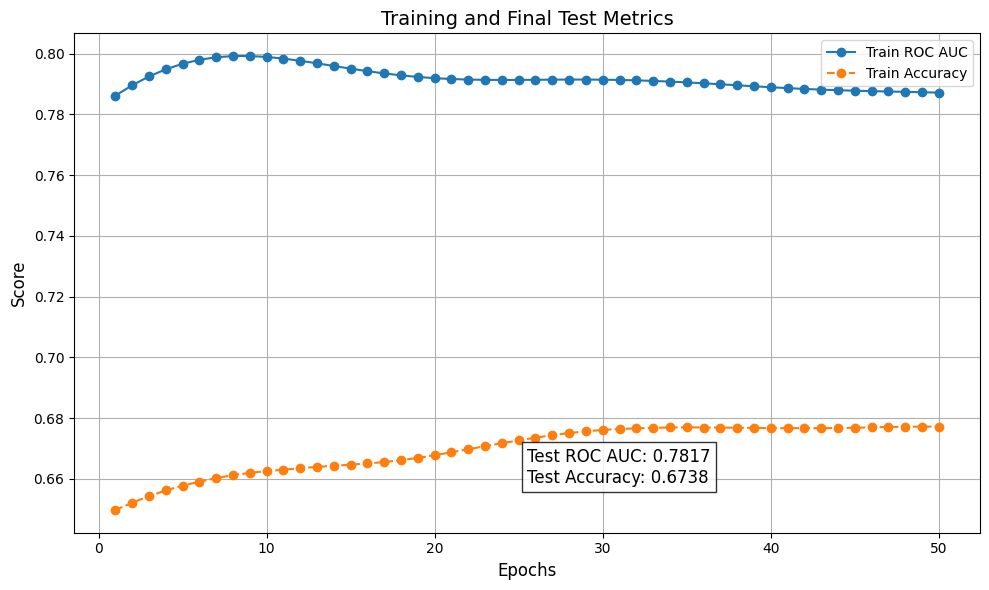

In [60]:
# Initialize lists to store training metrics
train_roc_auc = []
train_accuracy = []

# Training loop
for epoch in range(num_epochs):
    train_loss, train_auc, train_acc = train(model, g_main, g_train_pos, g_train_neg, optimizer)
    train_roc_auc.append(train_auc)
    train_accuracy.append(train_acc)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, AUC: {train_auc:.4f}, Accuracy: {train_acc:.4f}")

# Evaluate on the test set once after training
with torch.no_grad():
    test_loss, test_auc, test_acc = evaluate(model, g_main, g_test_pos, g_test_neg)

print(f"Final Test Results - Loss: {test_loss:.4f}, ROC AUC: {test_auc:.4f}, Accuracy: {test_acc:.4f}")

# Visualize training metrics with final test evaluation
visualize_training_with_test(train_roc_auc, train_accuracy, test_auc, test_acc, title="Training and Final Test Metrics")


#### Save the model

In [ ]:
# Save the model state
torch.save(model.state_dict(), 'graphsage_model.pth')
print("Model saved as 'graphsage_model.pth'")

Model saved as 'graphsage_model.pth'
